<a href="https://colab.research.google.com/github/seanreed1111/BDA_py_demos/blob/master/btyd_test_brian_callander_generate_simulated_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

see also: 
- https://www.briancallander.com/posts/customer_lifetime_value/pareto-nbd.html
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.Rmd
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
- https://github.com/mplatzer/BTYDplus/blob/master/R/pareto-nbd-mcmc.R
- https://cran.r-project.org/web/packages/BTYD/BTYD.pdf
- https://github.com/mplatzer/BTYDplus



In [1]:
# installlation required
!pip install pyro-ppl


     |████████████████████████████████| 713 kB 7.8 MB/s 


<a id = "7"></a><br>
# LIBRARIES

In [2]:
import os
import datetime as dt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import expon, poisson, invgamma, uniform, lognorm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [9, 6]
import warnings 
warnings.filterwarnings("ignore")

Let’s describe the model first by simulation. 

Suppose we have a company that is 2 years old and a total of 2000 customers, C, that have made at least one purchase from us. 

We’ll assume a linear rate of customer acquisition, so that the first purchase date is simply a uniform random variable over the 2 years of the company existance. These assumptions are just to keep the example concrete, and are not so important for understanding the model.

Each customer c∈C is assumed to have a certain lifetime, τc, starting on their join-date. 

During their lifetime, they will purchase at a constant rate, λc, so that they will make k∼Poisson(tλc) purchases over a time-interval t. 

Once their lifetime is over, they will stop purchasing. We only observe the customer for Tc units of time, and this observation time can be either larger or smaller than the lifetime, τc. 

Since we don’t observe τc itself, we will assume it follows an exponential distribution, i.e. τc∼Exp(μc).

In [6]:
def create_T(n=10, max_obs_time=200):
  '''
  input 
  int n = number of customers to generate
  int max_obs_time = max observation time in days

  output: 
  customer observation time array T[n]. 
  Each T[n] is in interval [0, max_obs_time]
  '''

  return uniform.rvs(0, max_obs_time, size=n)

In [23]:
T = create_T()
T

array([ 90.78245164,  63.13553682, 191.8134323 ,  60.35455361,
       119.7012043 , 114.63375656,  95.638578  ,  35.7824697 ,
        80.26060854,  95.07538428])

In [28]:
mean_period_between_purchases = 1 
mean_customer_lifetime = 100

In [35]:
def simulate_purchases(T, mean_customer_lifetime, mean_period_between_purchases):
  '''
  input: 
  T: observation time. This is the length of time they have been a customer
  mean_customer_lifetime: mean_customer_lifetime
  mean_period_between_purchases: mean_period_between_purchases

  output:
  k: number of purchases
  T: observation time. This is the length of time they have been a customer
  tau: actual lifetime for this customerm drawn from exponential distribution with mean_customer_lifetime
  t: time of customer's last purchase
  '''
  tau = expon.rvs(scale=mean_customer_lifetime) # actual lifetime for this customer
  t,k = 0,0 # t = purchase time, k = number of purchases
  wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
  while ((t + wait) <= min(T, tau)):
    t = t + wait
    k = k + 1
    wait = expon.rvs(scale=mean_period_between_purchases)
  return  k, T, tau, t #final value of t is time of last purchase

simulate_purchases_vec = np.vectorize(simulate_purchases)

1 4.75976464387631e-07 0.6929080987519038 1.0009286405840263 1.0024947647665239 13.438950235210575


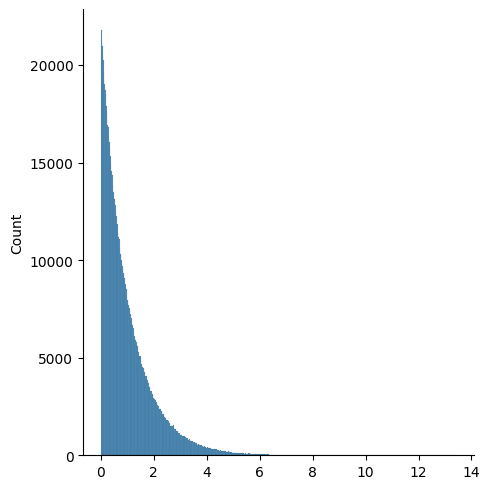

In [36]:
data = expon.rvs(scale=mean_period_between_purchases, size=1000000)
print(mean_period_between_purchases, data.min(), np.median(data), data.mean(), data.std(), data.max())
sns.displot(data=data);

100 0.0002014114420417349 69.41795489769862 100.07022035193448 99.99629086816206 1337.2514022808593


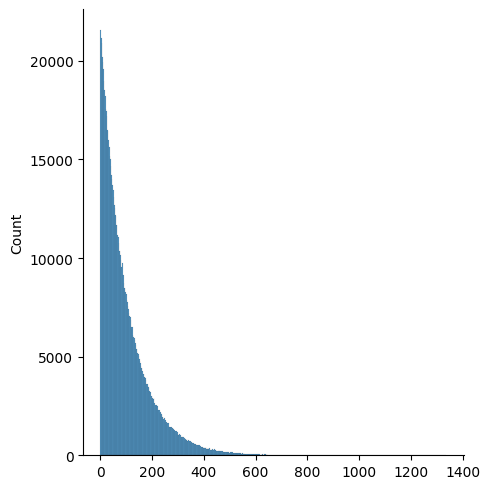

In [37]:
data = expon.rvs(scale=mean_customer_lifetime, size=1000000)
print(mean_customer_lifetime, data.min(), np.median(data), data.mean(), data.std(), data.max())
sns.displot(data=data);

In [38]:
simulate_purchases_vec(T, mean_customer_lifetime, mean_period_between_purchases)


(array([93, 60,  5,  2, 24,  0, 21, 29,  4, 42]),
 array([ 90.78245164,  63.13553682, 191.8134323 ,  60.35455361,
        119.7012043 , 114.63375656,  95.638578  ,  35.7824697 ,
         80.26060854,  95.07538428]),
 array([116.35955075,  48.59171837,   7.48375877,   0.86715912,
         28.6832344 ,   1.76315469,  14.28295049, 378.86520492,
          4.76639401,  42.69557929]),
 array([90.77567079, 48.26156242,  5.69068254,  0.38821391, 28.60555494,
         0.        , 13.54563896, 30.29566219,  4.24105329, 40.92471405]))

In [42]:
def create_data(*,n, mean_lifetime, mean_period_between_purchases, max_obs_time=200):
  '''
  input: 
  mean_lifetime
  mean_period_between_purchases
  n: number of customers,
  max_obs_time: maximum time the customer could have been observed

  output: 
  dataframe[['k','T','tau','t']] where

  k: number of purchases
  T: observation time. This is the length of time they have been a customer
  tau: actual lifetime for this customerm drawn from exponential distribution with scale=mean_customer_lifetime
  t: time of customer's last purchase
  '''
  T = create_T(n, max_obs_time)
  result = simulate_purchases_vec(T, mean_lifetime, mean_period_between_purchases)

  return pd.DataFrame(result, index=['k','T','tau','t']).T 


In [40]:
create_data(n=10, mean_lifetime =100, mean_period_between_purchases =1)

,k,T,tau,t_max
0,1.0,5.639245,1.059101,0.030868
1,59.0,60.751798,164.287549,59.892449
2,67.0,69.015532,139.265912,68.305884
3,142.0,125.782434,356.463870,125.198435
4,22.0,31.675192,12.558741,11.916658
5,33.0,82.737618,31.781039,31.161615
6,17.0,126.469858,11.922652,11.635730
7,194.0,195.826943,175.017481,174.261555
8,36.0,139.826753,36.178851,34.469707
9,20.0,17.776099,59.791641,17.702186


In [41]:
def loglik(Lambda, mu, t, T, k):
  target = k * torch.log(Lambda) - torch.log(Lambda + mu)
  n = Lambda.size(0)
  for i in range(n):
    target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
                                       torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
                                       )
  return target

In [ ]:
def model(t, T, k):
  '''
  input:
  t[n]  = time since most recent purchase
  T[n]  = total observation time
  k[n]  = number of purchases observed (k must be >= 2)

  n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
  n = number of customers
  etau_alpha, etau_beta are priors for etau
  Lambda_alpha, Lambda_beta are priors for Lambda
  '''


  with pyro.plate("data", t.size(0)):
    etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta))
    mu = 1./etau
    Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta))

  pyro.factor('loglik', loglik(Lambda, mu, t, T, k))

In [ ]:
Centered BTYD
# https://www.briancallander.com/posts/customer_lifetime_value/models/rf.stan
# data_hyperpriors <- list(
#   log_life_mean_mu = log(31),
#   log_life_mean_sigma = 0.7,
#   log_life_scale_sigma = 0.8,

#   log_lambda_mean_mu = log(1 / 14),
#   log_lambda_mean_sigma = 0.3,
#   log_lambda_scale_sigma = 0.5
# )
data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time to most recent purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases observed

  // user-specified parameters
  real<lower = 0> etau_mean_alpha;
  real<lower = 0> etau_mean_beta;
  real<lower = 0> etau_sd_alpha;
  real<lower = 0> etau_sd_beta;

  real<lower = 0> lambda_mean_alpha;
  real<lower = 0> lambda_mean_beta;
  real<lower = 0> lambda_sd_alpha;
  real<lower = 0> lambda_sd_beta;
}

parameters {
  vector<lower = 0>[n] lambda; // purchase rate
  vector<lower = 0>[n] etau;   // expected mean lifetime

  vector<lower = 0>[n] etau_mean; // mean expected life span
  vector<lower = 0>[n] etau_sd;
  vector<lower = 0>[n] lambda_mean; // mean purchase rate
  vector<lower = 0>[n] lambda_sd;

}

transformed parameters {
  vector<lower = 0>[n] etau_beta = etau_mean;
  vector<lower = 0>[n] etau_alpha = etau_sd;
  vector<lower = 0>[n] lambda_beta = lambda_mean ./ (lambda_sd .* lambda_sd);
  vector<lower = 0>[n] lambda_alpha = lambda_beta .* lambda_mean;

  vector<lower = 0>[n] mu = 1.0 ./ etau;
}

model {
  // hyperpriors
  etau_mean ~ gamma(etau_mean_alpha, etau_mean_beta);
  etau_sd ~ gamma(etau_sd_alpha, etau_sd_beta);

  lambda_mean ~ gamma(lambda_mean_alpha, lambda_mean_beta);
  lambda_sd ~ gamma(lambda_sd_alpha, lambda_sd_beta);

  // priors
  etau ~ inv_gamma(etau_alpha, etau_beta);
  lambda ~ gamma(lambda_alpha, lambda_beta);

  // likelihood
  target += k .* log(lambda) - log(lambda + mu);
  for (i in 1:n) {
    target += log_sum_exp(
      log(lambda[i]) - (lambda[i] + mu[i]) .* T[i],
      log(mu[i]) - (lambda[i] + mu[i]) .* t[i]
    );
  }
}


In [ ]:
# non-centered BTYD
# https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
# https://www.briancallander.com/posts/customer_lifetime_value/models/rf_noncentred.stan

data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time between first and last purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases

  // hyperparameters for the expected lifetime
  real log_life_mean_mu;
  real<lower = 0> log_life_mean_sigma;
  // hyperparameter for scale of customer-level lifetime effects
  real<lower = 0> log_life_scale_sigma;

  // hyperparameters for the expected purchase rate
  real log_lambda_mean_mu;
  real<lower = 0> log_lambda_mean_sigma;
  // hyperparameter for scale of customer-level purchase-rate effects
  real<lower = 0> log_lambda_scale_sigma;

  // flag whether to only sample from the prior
  // to draw from the prior-predictive distribution: prior_only = 1
  // to draw from the posterior distribution: prior_only = 0
  int<lower = 0, upper = 1> prior_only;
}

transformed data {
  vector<lower = 0, upper = 0>[2] zero = rep_vector(0, 2);
  vector[2] J = [-1, 1]';
  vector[2] m = [log_life_mean_mu, log_lambda_mean_mu]';
  matrix<lower = 0>[2, 2] m_sigma = diag_matrix([log_life_mean_sigma, log_lambda_mean_sigma]');
  matrix<lower = 0>[2, 2] s_sigma = diag_matrix([log_life_scale_sigma, log_lambda_scale_sigma]');
}

parameters {
  row_vector[2] log_centres;
  vector<lower = 0>[2] scales;
  matrix[n, 2] customer; // customer-level effects
}

transformed parameters {
  matrix<lower = 0>[n, 2] theta = exp(
    diag_post_multiply(
      rep_matrix(log_centres, n) + diag_post_multiply(customer, scales),
      J
    )
  ); // (mu, lambda)
}

model {
  // priors
  log_centres ~ multi_normal_cholesky(m, m_sigma);
  scales ~ multi_normal_cholesky(zero, s_sigma);

  for (i in 1:n) {

    customer[i, ] ~ std_normal();

    // likelihood
    if (prior_only == 0) {
      target += log_sum_exp(
        log(theta[i, 2]) - (theta[i, 2] + theta[i, 1]) .* T[i],
        log(theta[i, 1]) - (theta[i, 2] + theta[i, 1]) .* t[i]
      );
    }
  }

  if (prior_only == 0) {
    target += k .* log(theta[, 2]) - log(theta[, 2] + theta[, 1]);
  }

}
